In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from string import punctuation
from matplotlib import pyplot as plt

from sklearn import metrics, mixture, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import word2vec

import nltk, string
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, cosine_distance, euclidean_distance
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# filepath = f"{os.path.dirname(__file__)}\\..\\data"
filepath = "..\\data"

train = pd.read_csv(f"{filepath}\\train.csv")
train_text = train["text"]

test = pd.read_csv(f"{filepath}\\test.csv")
test_text, test_label = test["text"], test["label"].values


In [17]:


def all_stop_list(additional=None, include_defaults=True):
    """
    Generate a custom list of stop words.

    Parameters:
    - additional (list of str): Additional words to include as stop words.
    - include_defaults (bool): Whether to include default English stop words from NLTK and CountVectorizer.

    Returns:
    - list of str: The combined list of stop words.
    """
    all_stop_words = set()

    # Include default stop words from NLTK and CountVectorizer
    if include_defaults:
        defaults_nltk = set(stopwords.words('english'))
        vectorizer = CountVectorizer(stop_words='english')
        defaults_cv = set(vectorizer.get_stop_words())
        all_stop_words = defaults_nltk.union(defaults_cv)

    # Add any additional specified stop words
    if additional:
        all_stop_words = all_stop_words.union(additional)

    return list(all_stop_words)

def fit_vectorizer(train_text, vectorizer=TfidfVectorizer, extra_stop_words=["like", "would"]):
    # remove new line chars to prevent tokenization errors
    train_text = train_text.apply(lambda doc: ' '.join(' '.join(doc.split('\n')).split('\\n')))

    all_stop_words = all_stop_list(additional=extra_stop_words)

    # set vectorizer params
    vec_params = {
        'stop_words':all_stop_words,                    # nltk stopwords + custom stopwords
        'min_df': 5,                                    # token must appear in at least 5 docs
        'strip_accents':'unicode',                      # token normalization by stripping accents and other punctuation
        'token_pattern':r'\b[a-zA-Z]{3,}\b'}            # only keep non-numeric tokens over 2 letters

    # intialize and fit tfidf vectorizer
    tfidf_vec = vectorizer(**vec_params).fit(train_text)

    return tfidf_vec

def format_confusion_matrix(test_label, predicted, n_clusters):

    # create df with ground truth labels and predicted cluster ids
    confusion_df = pd.DataFrame(list(zip(test_label, predicted)), columns=["label", "cluster"])

    # use confusion matrix to map cluster id to true labels by majority vote
    cluster_labels = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)
    cluster_map = {i:cluster_labels.loc[i].idxmax() for i in range(n_clusters)}
    cluster_map = {k: cluster_map[k] for k in sorted(cluster_map)}

    # Map true label to cluster id
    predicted_topic = [cluster_map[i]  for i in predicted]

    # print classification report
    best_report = metrics.classification_report(test_label, predicted_topic)
    print(best_report)

    return cluster_map

def plot_pca(predicted, test_dtm, test_label, cluster_map, n_components=2, palette=["orange", "red", "blue", "green"]):
    """ """

    # get pca from test predictions
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(test_dtm.toarray())

    # map colors for scatter plots
    pred_palette, gt_palette = [dict(zip(id, palette)) for id in zip(*cluster_map.items())]

    plt.figure(figsize=(16, 4))
    plt.suptitle("PCA", fontsize=16)

    plt.subplot(1,2,1)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=test_label, palette=gt_palette)
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=predicted, palette=pred_palette)
    plt.title("Predicted")

    plt.show()

def plot_tsne(predicted, test_dtm, test_label, cluster_map, n_components=2, palette=["orange", "red", "blue", "green"]):
    """ """

    # get tsne from test predictions
    model = TSNE(n_components=n_components, perplexity=1000)
    X = model.fit_transform(test_dtm.toarray())

    # map colors for scatter plots
    pred_palette, gt_palette = [dict(zip(id, palette)) for id in zip(*cluster_map.items())]

    plt.figure(figsize=(16, 4))
    plt.suptitle("t-SNE", fontsize=16)

    plt.subplot(1,2,1)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=test_label, palette=gt_palette)
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=predicted, palette=pred_palette)
    plt.title("Predicted")

    plt.show()

def cluster_kmean(train_text, test_text, test_label, n_clusters, n_top_words=10):

    print(f"\nK-Means Clustering, {n_clusters} clusters\n")

    # fit vectorizer and transform train data to get doc term matrix
    tfidf_vectorizer = fit_vectorizer(train_text)
    train_dtm = tfidf_vectorizer.transform(train_text)

    # init clustering model with 4 clusters using cosine distance, try 20 different centroid seeds
    clusterer = KMeansClusterer(n_clusters, cosine_distance, repeats=20)
    # assign cluster labels / "fit" model
    clusterer.cluster(train_dtm.toarray(), assign_clusters=True)

    # each row is a cluster, and each column is a feature (word); sort in ascending (reverse) order
    centroids = np.array(clusterer.means())
    sorted_centroids = centroids.argsort()[:, ::-1]
    # locations of features before sorting
    voc_lookup = tfidf_vectorizer.get_feature_names_out()

    # transform test set with fitted vectorizer and predict clusters
    test_dtm = tfidf_vectorizer.transform(test_text)
    predicted = [clusterer.classify(v) for v in test_dtm.toarray()]

    # Display the confusion matrix
    cluster_map = format_confusion_matrix(test_label, predicted, n_clusters)

    # print top words per cluster
    print(f"\nTop {n_top_words} Words per Cluster")
    for pred_label, gt_label in cluster_map.items():
        words = [voc_lookup[word_idx] for word_idx in sorted_centroids[pred_label, :n_top_words]]
        print(f"Cluster {pred_label}, True Label {gt_label}: {words}\n")

    # plot pca for predictions and ground truth data
    plot_pca(predicted, test_dtm, test_label, cluster_map)

    return predicted, test_dtm

def gmm_grid_search(train_text, n_components, n_init=2):

    # Grid search to find optimal params
    tfidf_vec = fit_vectorizer(train_text)
    # transform train data to get doc term matrix
    train_dtm = tfidf_vec.transform(train_text).toarray()

    # We use a small scope of grid search to find the best parameters of GMM
    lowest_bic = np.infty   # initial BIC is set to infinity
    best_gmm = None

    # The covariance type, for details check https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.aic
    cv_types = [
        'spherical',                    # each component has its own single variance
        'tied',                         # all components share the same general covariance matrix
        'diag',                         # each component has its own diagonal covariance matrix
        'full'                          # each component has its own general covariance matrix
        ]

    for cv_type in cv_types:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                        n_init=n_init,
                                        covariance_type=cv_type,
                                        random_state=42
                                        )

        # get BIC (Bayesian Information Criterion) for the current model
        bic = gmm.fit(train_dtm).bic(train_dtm)

        # update best model if lower BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm

    print(f"Best GMM:\nn_components = {n_components}\ncovariance_type = {cv_type}\nBIC = {bic}")
    # lowest_bic
    return best_gmm

def cluster_gmm(train_text, test_text, test_label, n_clusters, n_top_words=10):

    tfidf_vectorizer = fit_vectorizer(train_text)
    # transform data to get doc term matrix
    train_dtm = tfidf_vectorizer.transform(train_text)
    test_dtm = tfidf_vectorizer.transform(test_text)

    # gmm_model = gmm_grid_search(train_text, n_clusters)
    gm_model = mixture.GaussianMixture(n_components=n_clusters,
                                        n_init=2,
                                        covariance_type="diag"
                                        )
    gm_model.fit(train_dtm.toarray())

    # predict clusters from test dtm
    predicted = gm_model.predict(test_dtm.toarray())
    tf_feature_names = tfidf_vectorizer.get_feature_names_out()


    # Display the confusion matrix
    cluster_map = format_confusion_matrix(test_label, predicted, n_clusters)
    # print top words per cluster
    print(f"\nTop {n_top_words} Words per Cluster")
    for pred_label, gt_label in cluster_map.items():
        # Get indices of top words in this cluster
        top_indices = np.argsort(gm_model.means_[pred_label])[-n_top_words:]
        words = [tf_feature_names[idx] for idx in top_indices]
        print(f"Cluster {pred_label}, True Label {gt_label}: {words}\n")

    # plot pca for predictions and ground truth data
    plot_pca(predicted, test_dtm, test_label, cluster_map)

    return predicted, test_dtm

def cluster_lda(train_text, test_text, test_label, n_clusters, n_top_words=10):

    # fit vectorizer using raw term counts for LDA
    tfidf_vectorizer = fit_vectorizer(train_text, vectorizer=CountVectorizer)

    # Transform the test text to a TF-IDF representation
    train_dtm = tfidf_vectorizer.transform(train_text)
    test_dtm = tfidf_vectorizer.transform(test_text)

    # Initialize the LDA model
    lda = LatentDirichletAllocation(n_components=n_clusters, max_iter=30, learning_offset=40.0, learning_method='online',
                                    verbose=1, evaluate_every=5, n_jobs=1, random_state=0).fit(train_dtm.toarray())
    predicted_labels = lda.transform(test_dtm.toarray())

    # Print the top words for each topic
    # Generate topic assignment for each test document
    tf_feature_names = tfidf_vectorizer.get_feature_names_out()
    predicted = [label.argmax() for label in predicted_labels]

    # Display the confusion matrix
    cluster_map = format_confusion_matrix(test_label, predicted, n_clusters)

    print(f"Top {n_top_words} Words per Cluster")
    for topic_idx, topic in enumerate(lda.components_):
        words = [tf_feature_names[i] for i in topic.argsort()[::-1][0:n_top_words]]
        print(f"Cluster {topic_idx}, True Label {cluster_map[topic_idx]}: {words}\n")

    # show t-SNE
    plot_tsne(predicted, test_dtm, test_label, cluster_map)
    # plot_tsne(predicted)

    return predicted, test_dtm



## K-Means Clustering



K-Means Clustering, 4 clusters

              precision    recall  f1-score   support

           1       0.82      0.70      0.76       332
           2       0.92      0.66      0.77       314
           3       0.72      0.90      0.80       355
           7       0.69      0.81      0.74       273

    accuracy                           0.77      1274
   macro avg       0.79      0.77      0.77      1274
weighted avg       0.79      0.77      0.77      1274


Top 10 Words per Cluster
Cluster 0, True Label 2: ['water', 'energy', 'light', 'earth', 'number', 'equation', 'mass', 'air', 'speed', 'gas']

Cluster 1, True Label 7: ['com', 'job', 'business', 'www', 'money', 'work', 'credit', 'want', 'good', 'pay']

Cluster 2, True Label 3: ['help', 'weight', 'know', 'body', 'doctor', 'really', 'time', 'good', 'think', 'feel']

Cluster 3, True Label 1: ['god', 'people', 'jesus', 'think', 'believe', 'bible', 'religion', 'life', 'know', 'christians']



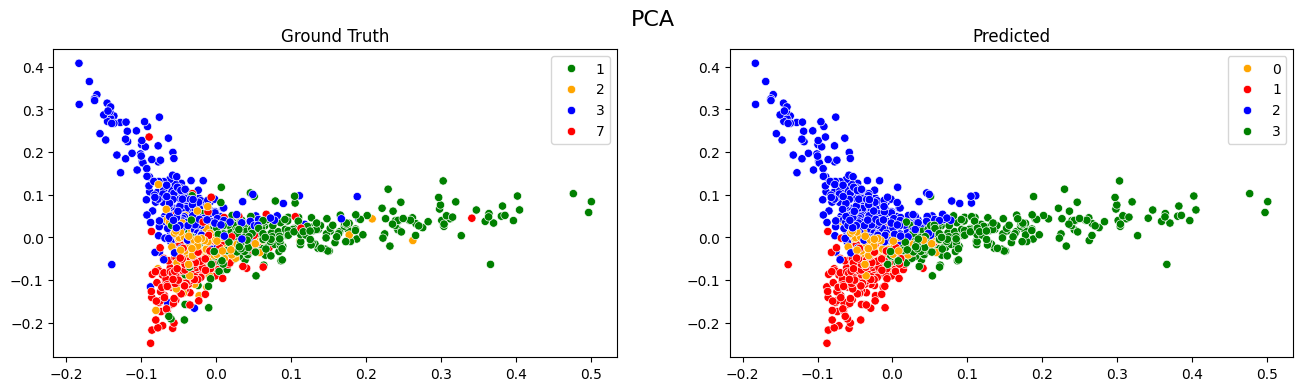

In [ ]:

predicted, test_dtm = cluster_kmean(train_text, test_text, test_label, n_clusters=4)


## GMM Clustering

              precision    recall  f1-score   support

           1       0.60      0.35      0.44       332
           2       0.78      0.72      0.75       314
           3       0.85      0.63      0.72       355
           7       0.39      0.75      0.51       273

    accuracy                           0.60      1274
   macro avg       0.65      0.61      0.61      1274
weighted avg       0.67      0.60      0.61      1274



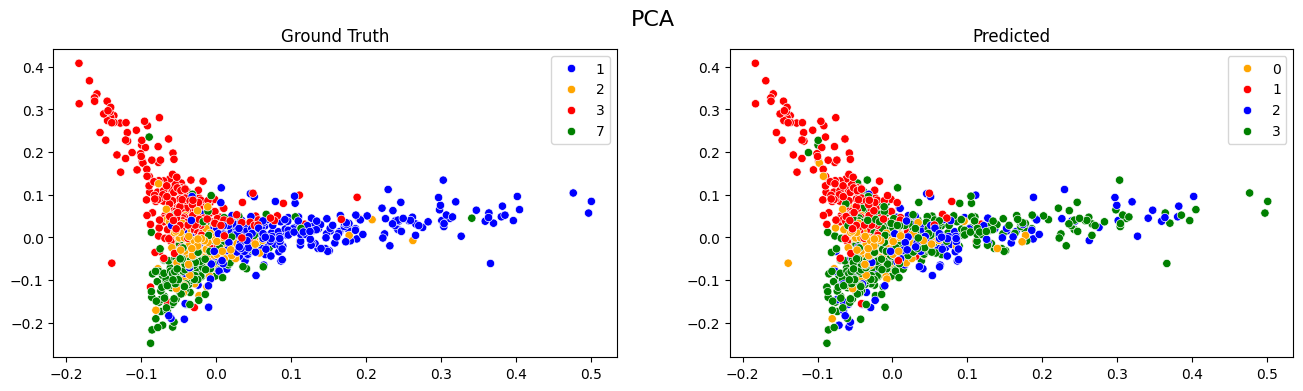

In [ ]:

predicted, test_dtm = cluster_gmm(train_text, test_text, test_label, n_clusters=4)


## LDA Clustering

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 2335.8045
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 2306.1691
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 2298.3358
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 2294.7422
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 2292.6111
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_ite

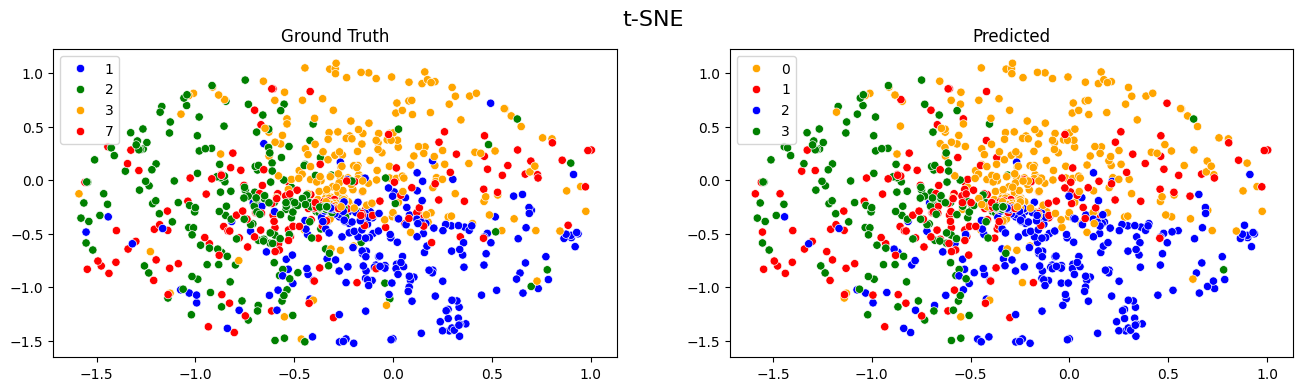

In [18]:

predicted, test_dtm = cluster_lda(train_text, test_text, test_label, n_clusters=4)
